#### Explore the Home Credit Dataset

This part is important in creating an understanding of the data. Making sense of the data will enable us to create a strategy for preprocessing, deal with missing values and outliers, which all contribute to model stability.

In [1]:
# Import the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import numpy as np
import gc
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import math
import pickle
import os

In [3]:
## Function to reduce memory usage since the dataset is large
## Ref: https://www.kaggle.com/code/rinnqd/reduce-memory-usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

#### Explore the Train set
The train set (application_train.csv) file is the main dataset, which has the Train and the Test sets. Each row is a representation of one loan application.


In [9]:
train_data = reduce_mem_usage(pd.read_csv("../data/raw/application_train.csv"))
train_data.shape
train_data.head() # Check first five rows

Memory usage after optimization is: 92.38 MB
Decreased by 67.7%


/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_7016/608378887.py:21: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_7016/608378887.py:21: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_7016/608378887.py:21: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_7016/608378887.py:21: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/opt/anaconda3/lib/python3.13/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/opt/anaconda3/lib/python

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


The train data has 307511 rows and 122 columns.

In [10]:
test_data = reduce_mem_usage(pd.read_csv("../data/raw/application_test.csv"))
test_data.shape
test_data.head() # Check first five rows

Memory usage after optimization is: 14.60 MB
Decreased by 67.6%


/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_7016/608378887.py:21: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_7016/608378887.py:21: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_7016/608378887.py:21: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_7016/608378887.py:21: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/opt/anaconda3/lib/python3.13/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/opt/anaconda3/lib/python

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


The test data is one column less - the target column.

#### Explore the Bureau datasets
This dataset contains all client’s previous credits  provided by other institutions.

In [20]:
bureau_data = reduce_mem_usage(pd.read_csv("../data/raw/bureau.csv"))
print('Number of rows : ', bureau_data.shape[0])
bureau_data.head() # Check first five rows

Memory usage after optimization is: 112.95 MB
Decreased by 49.3%
Number of rows :  1716428


/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_7016/608378887.py:21: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_7016/608378887.py:21: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_7016/608378887.py:21: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_7016/608378887.py:21: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_7016/608378887.py:21: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.floa

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [21]:
bureau_balance_data = reduce_mem_usage(pd.read_csv("../data/raw/bureau_balance.csv"))
print('Number of rows : ', bureau_balance_data.shape[0])
bureau_balance_data.head() # Check first five rows

Memory usage after optimization is: 338.46 MB
Decreased by 45.8%
Number of rows :  27299925


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [22]:
previous_application_data = reduce_mem_usage(pd.read_csv("../data/raw/previous_application.csv"))
print('Number of rows : ', previous_application_data.shape[0])
print('Number of columns : ', previous_application_data.shape[1])
previous_application_data.head() # Check first five rows

Memory usage after optimization is: 309.01 MB
Decreased by 34.5%
Number of rows :  1670214
Number of columns :  37


/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_7016/608378887.py:21: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_7016/608378887.py:21: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_7016/608378887.py:21: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_7016/608378887.py:21: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_7016/608378887.py:21: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.floa

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
pos_cash_data = reduce_mem_usage(pd.read_csv("../data/raw/POS_CASH_balance.csv"))
print('Number of rows : ', pos_cash_data.shape[0])
print('Number of columns : ', pos_cash_data.shape[1])
pos_cash_data.head() # Check first five rows

Memory usage after optimization is: 238.45 MB
Decreased by 60.9%
Number of rows :  10001358
Number of columns :  8


/opt/anaconda3/lib/python3.13/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [24]:
installments = reduce_mem_usage(pd.read_csv("../data/raw/installments_payments.csv"))
print('Number of rows : ', installments.shape[0])
print('Number of columns : ', installments.shape[1])
installments.head() # Check first five rows

Memory usage after optimization is: 311.40 MB
Decreased by 62.5%
Number of rows :  13605401
Number of columns :  8


/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_7016/608378887.py:21: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_7016/608378887.py:21: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/opt/anaconda3/lib/python3.13/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


In [25]:
credit_card_bal = reduce_mem_usage(pd.read_csv("../data/raw/credit_card_balance.csv"))
print('Number of rows : ', credit_card_bal.shape[0])
print('Number of columns : ', credit_card_bal.shape[1])
credit_card_bal.head() # Check first five rows

Memory usage after optimization is: 289.33 MB
Decreased by 57.1%
Number of rows :  3840312
Number of columns :  23


/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_7016/608378887.py:21: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_7016/608378887.py:21: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_7016/608378887.py:21: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_7016/608378887.py:21: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_7016/608378887.py:21: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.floa

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


From the above, we deduce that the dataset is large. There are hundreds of features and in some instances millions of rows. More importantly, the "SK_ID_PREV" column is noted to be the foreign key for the tables. This is useful when doing table joins.

### Further EDA on the Applications Dataset

Number of customers did not repay the loan on time:  24825 , ( 8.072881945686495 %)
Number of customers repaid the loan on time:  282686 , ( 91.92711805431351 %)


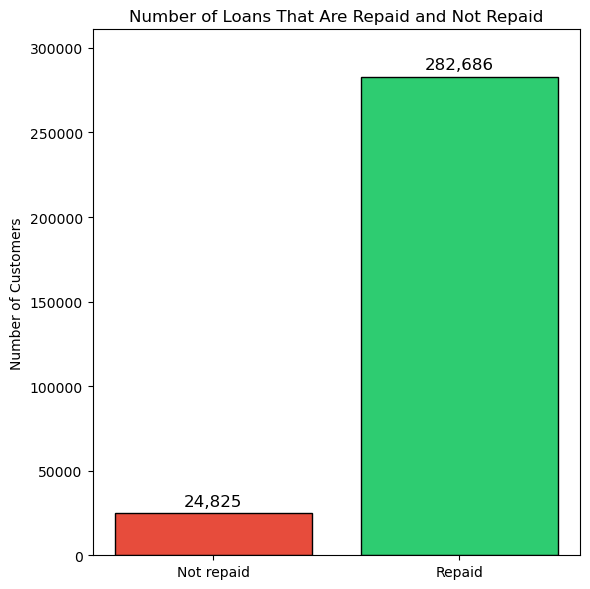

In [26]:
## Explore the distribution of classes

import matplotlib.pyplot as plt
import numpy as np

y_value_counts = train_data['TARGET'].value_counts()
print("Number of customers did not repay the loan on time: ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of customers repaid the loan on time: ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")

# Define labels and data
labels = ['Not repaid', 'Repaid']
data = [y_value_counts[1], y_value_counts[0]]

# Create bar chart
fig, ax = plt.subplots(figsize=(6, 6))
bars = ax.bar(labels, data, color=['#E74C3C', '#2ECC71'], edgecolor='black')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + max(data)*0.01,
            f'{height:,}', ha='center', va='bottom', fontsize=12)

# Add labels and title
ax.set_ylabel('Number of Customers')
ax.set_title('Number of Loans That Are Repaid and Not Repaid')
ax.set_ylim(0, max(data) * 1.1)

plt.tight_layout()
plt.show()


Class imbalances are observed in the dataset as a majority of the customers repaid the loans. This implies that our approach needs a method that is not affected by class imbalances

In [28]:
### Functions to create a few more plots

def stack_plot(data, xtick, col2='TARGET', col3='total'):
    ind = np.arange(data.shape[0])
    
    if len(data[xtick].unique())<5:
        plt.figure(figsize=(5,5))
    elif len(data[xtick].unique())>5 & len(data[xtick].unique())<10:
        plt.figure(figsize=(7,7))
    else:
        plt.figure(figsize=(15,15))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Loans')
    plt.title('Number of loans aproved vs rejected')
    plt.xticks(ticks=ind,rotation=90,labels= list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('capable', 'not capable'))
    plt.show()
    
    
def univariate_barplots(data, col1, col2='TARGET', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    temp = pd.DataFrame(train_data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp['total'] = pd.DataFrame(train_data.groupby(col1)[col2].agg(total='count')).reset_index()['total']
    temp['Avg'] = pd.DataFrame(train_data.groupby(col1)[col2].agg(Avg='mean')).reset_index()['Avg']
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print("="*50)
    print(temp.tail(5))

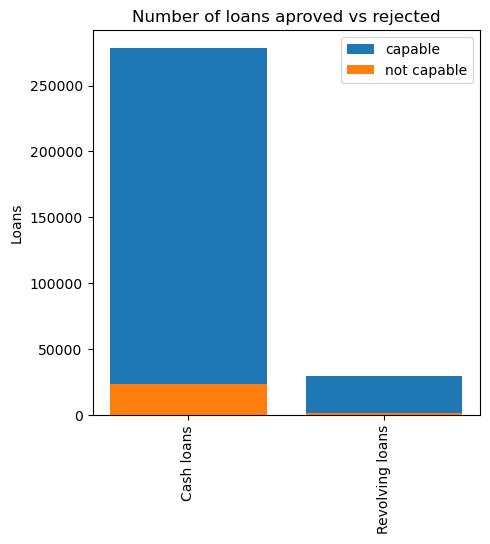

In [31]:
# Call the function to see the number of loans approved or rejected (cash vs non-cash)
data_grouped = train_data.groupby('NAME_CONTRACT_TYPE')['TARGET'].agg(['count', 'sum']).reset_index()
data_grouped.rename(columns={'count': 'total', 'sum': 'TARGET'}, inplace=True)

stack_plot(data_grouped, xtick='NAME_CONTRACT_TYPE')


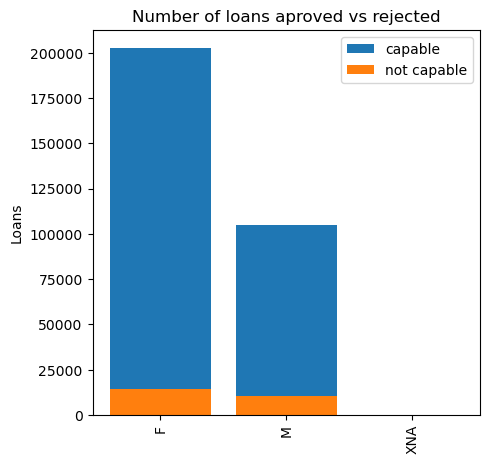

In [32]:
# Group by gender 
data_gender = train_data.groupby('CODE_GENDER')['TARGET'].agg(['count', 'sum']).reset_index()
data_gender.rename(columns={'count': 'total', 'sum': 'TARGET'}, inplace=True)

# Call the stack_plot function on gender
stack_plot(data_gender, xtick='CODE_GENDER')


Interesting to see that more females than males took loans. Men are also more likely to repay the loans than women. 

#### Analysis on ‘Name_Income_Type’ and ‘Name_Family_Status’

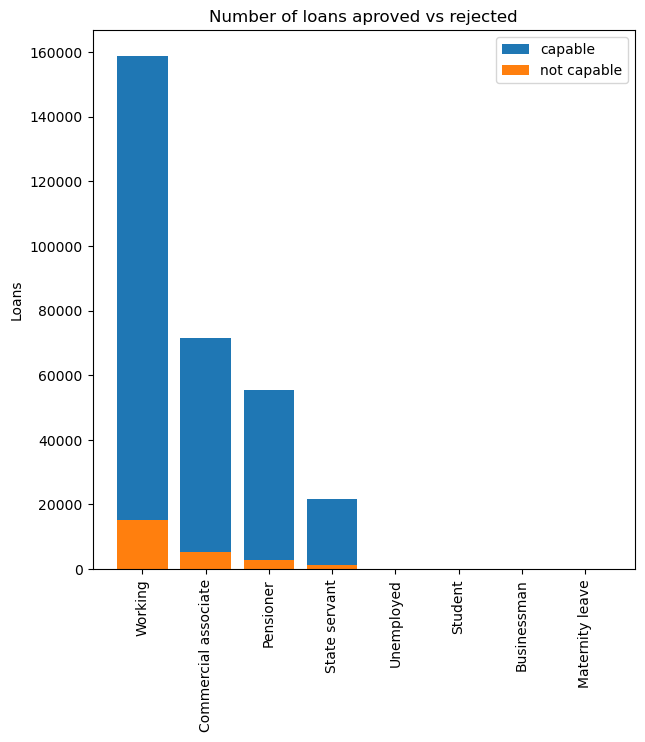

       NAME_INCOME_TYPE  TARGET   total       Avg
7               Working   15224  158774  0.095885
1  Commercial associate    5360   71617  0.074843
3             Pensioner    2982   55362  0.053864
4         State servant    1249   21703  0.057550
6            Unemployed       8      22  0.363636
  NAME_INCOME_TYPE  TARGET  total       Avg
4    State servant    1249  21703  0.057550
6       Unemployed       8     22  0.363636
5          Student       0     18  0.000000
0      Businessman       0     10  0.000000
2  Maternity leave       2      5  0.400000


In [34]:
## Income Type
univariate_barplots(train_data, col1='NAME_INCOME_TYPE')


The working class is more likely to repay loans as compared to the other groups. State servants are likley not to repay loans. This is useful when thinking through customer segmentation.

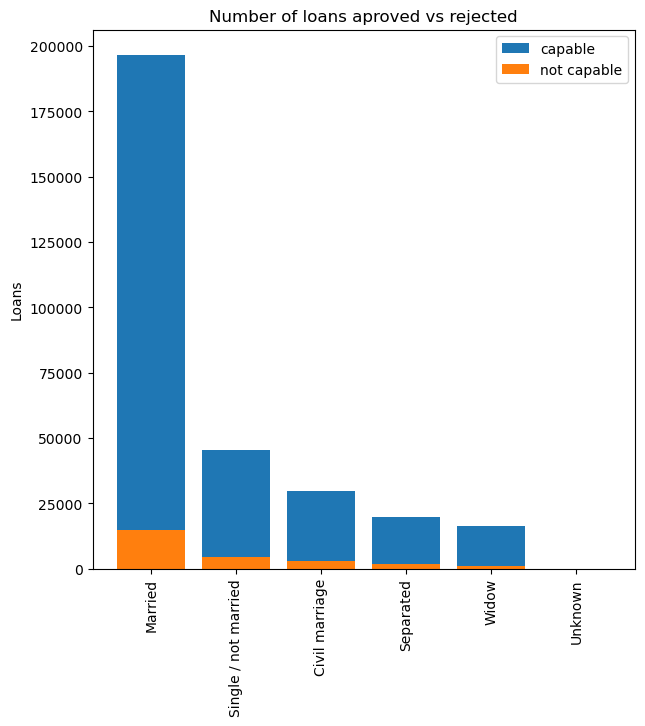

     NAME_FAMILY_STATUS  TARGET   total       Avg
1               Married   14850  196432  0.075599
3  Single / not married    4457   45444  0.098077
0        Civil marriage    2961   29775  0.099446
2             Separated    1620   19770  0.081942
5                 Widow     937   16088  0.058242
     NAME_FAMILY_STATUS  TARGET  total       Avg
3  Single / not married    4457  45444  0.098077
0        Civil marriage    2961  29775  0.099446
2             Separated    1620  19770  0.081942
5                 Widow     937  16088  0.058242
4               Unknown       0      2  0.000000


In [36]:
## Family status
univariate_barplots(train_data, col1='NAME_FAMILY_STATUS')

Married families are likely to repay as opposed to the widows and those that are separated.

/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_7016/3515539442.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data['HIGH_CREDIT_FLAG'] = (train_data['AMT_CREDIT'] > train_data['AMT_CREDIT'].median()).astype(int)


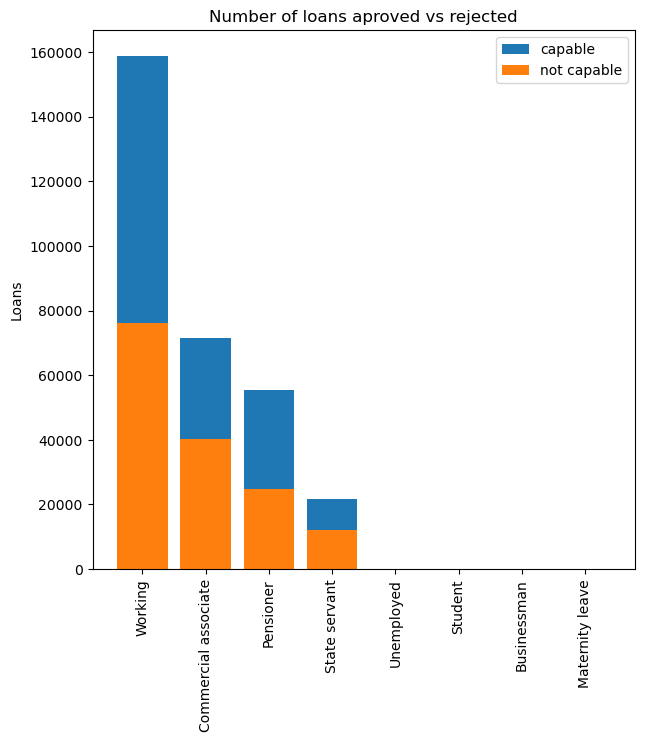

       NAME_INCOME_TYPE  HIGH_CREDIT_FLAG   total       Avg
7               Working             76159  158774  0.479669
1  Commercial associate             40321   71617  0.563009
3             Pensioner             24916   55362  0.450056
4         State servant             12229   21703  0.563470
6            Unemployed                16      22  0.727273
  NAME_INCOME_TYPE  HIGH_CREDIT_FLAG  total       Avg
4    State servant             12229  21703  0.563470
6       Unemployed                16     22  0.727273
5          Student                10     18  0.555556
0      Businessman                 8     10  0.800000
2  Maternity leave                 3      5  0.600000


In [39]:
# Binary flag for high credit amount
train_data['HIGH_CREDIT_FLAG'] = (train_data['AMT_CREDIT'] > train_data['AMT_CREDIT'].median()).astype(int)

# Call function to compare income type and credit flag
univariate_barplots(train_data, col1='NAME_INCOME_TYPE', col2='HIGH_CREDIT_FLAG')


Applicants with a Higher Value of Credit Amount across various income types have a Higher Likelihood of being deemed capable of Loan Repayment.

### Handling Null Values and Outliers - Application Train Dataset
Using a function, we fill null values and outliers using mode imputation for the categorical columns.

##### a. Days_Birth

In [43]:
print("The shape of the train dataset = ",train_data.shape)
train_data['DAYS_BIRTH'].describe()

The shape of the train dataset =  (307511, 124)


count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

##### b. Days_Employed
The column 'Days_Employed' refers to the number of days before the loan application that the applicant has been working. It is relative to the application date hence values must be negative

In [44]:
# Explore the days employed
train_data['DAYS_EMPLOYED'].describe()
train_data.replace(max(train_data['DAYS_EMPLOYED'].values), np.nan, inplace=True)

/opt/anaconda3/lib/python3.13/site-packages/pandas/core/dtypes/cast.py:1860: RuntimeWarning: overflow encountered in cast
  casted = dtype.type(element)


In [ ]:
def handle_nulls_outliers(data):
        
    data['NAME_FAMILY_STATUS'].fillna('Data_Not_Available', inplace=True)
    data['NAME_HOUSING_TYPE'].fillna('Data_Not_Available', inplace=True)

    data['FLAG_MOBIL'].fillna('Data_Not_Available', inplace=True)
    data['FLAG_EMP_PHONE'].fillna('Data_Not_Available', inplace=True)
    data['FLAG_CONT_MOBILE'].fillna('Data_Not_Available', inplace=True)
    data['FLAG_EMAIL'].fillna('Data_Not_Available', inplace=True)

    data['OCCUPATION_TYPE'].fillna('Data_Not_Available', inplace=True)

    #Replace NA with the most frequently occuring class for Count of Client Family Members
    data['CNT_FAM_MEMBERS'].fillna(data['CNT_FAM_MEMBERS'].value_counts().idxmax(), \
                                             inplace=True)
        
    data.replace(max(data['DAYS_EMPLOYED'].values), np.nan, inplace=True)

    data['CODE_GENDER'].replace('XNA','M',inplace=True)
    #There are a total of 4 applicants with Gender provided as 'XNA'

    data['AMT_ANNUITY'].fillna(0, inplace=True)
    #A total of 36 datapoints are there where Annuity Amount is null.

    data['AMT_GOODS_PRICE'].fillna(0, inplace=True)
    #A total of 278 datapoints are there where Annuity Amount is null.

    data['NAME_TYPE_SUITE'].fillna('Unaccompanied', inplace=True)
    #Removing datapoints where 'Name_Type_Suite' is null.

    data['NAME_FAMILY_STATUS'].replace('Unknown','Married', inplace=True)
    #Removing datapoints where 'Name_Family_Status' is Unknown.

    data['OCCUPATION_TYPE'].fillna('Data_Not_Available', inplace=True)

    data['EXT_SOURCE_1'].fillna(0, inplace=True)
    data['EXT_SOURCE_2'].fillna(0, inplace=True)
    data['EXT_SOURCE_3'].fillna(0, inplace=True)
    
    return data

In [46]:
train_data = handle_nulls_outliers(train_data)
train_data.shape

/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_7016/661828019.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['NAME_FAMILY_STATUS'].fillna('Data_Not_Available', inplace=True)
/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_7016/661828019.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are se

(307511, 124)

### Feature Engineering on Application data

In [51]:
def FE_application_data(data):
    # --- Core ratio & interaction features ---
    data['CREDIT_INCOME_PERCENT'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
    data['ANNUITY_INCOME_PERCENT'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
    data['CREDIT_ANNUITY_PERCENT'] = data['AMT_CREDIT'] / data['AMT_ANNUITY']
    data['FAMILY_CNT_INCOME_PERCENT'] = data['AMT_INCOME_TOTAL'] / data['CNT_FAM_MEMBERS']
    data['CREDIT_TERM'] = data['AMT_ANNUITY'] / data['AMT_CREDIT']
    data['BIRTH_EMPLOYED_PERCENT'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
    data['CHILDREN_CNT_INCOME_PERCENT'] = data['AMT_INCOME_TOTAL'] / data['CNT_CHILDREN']
    data['CREDIT_GOODS_DIFF'] = data['AMT_CREDIT'] - data['AMT_GOODS_PRICE']
    data['EMPLOYED_REGISTRATION_PERCENT'] = data['DAYS_EMPLOYED'] / data['DAYS_REGISTRATION']
    data['BIRTH_REGISTRATION_PERCENT'] = data['DAYS_BIRTH'] / data['DAYS_REGISTRATION']
    data['ID_REGISTRATION_DIFF'] = data['DAYS_ID_PUBLISH'] - data['DAYS_REGISTRATION']
    data['ANNUITY_LENGTH_EMPLOYED_PERCENT'] = data['CREDIT_TERM'] / data['DAYS_EMPLOYED']

    # Age at loan finish:
    # current age (in years) + loan term in years
    data['AGE_LOAN_FINISH'] = (
        data['DAYS_BIRTH'] * (-1.0 / 365)
        + (data['AMT_CREDIT'] / data['AMT_ANNUITY']) * (1.0 / 12)
    )
    # (This is the client's age when they finish repaying the loan)

    data['CAR_AGE_EMP_PERCENT'] = data['OWN_CAR_AGE'] / data['DAYS_EMPLOYED']
    data['CAR_AGE_BIRTH_PERCENT'] = data['OWN_CAR_AGE'] / data['DAYS_BIRTH']
    data['PHONE_CHANGE_EMP_PERCENT'] = data['DAYS_LAST_PHONE_CHANGE'] / data['DAYS_EMPLOYED']
    data['PHONE_CHANGE_BIRTH_PERCENT'] = data['DAYS_LAST_PHONE_CHANGE'] / data['DAYS_BIRTH']

    # --- Group-based median income encodings ---
    income_by_contract = (
        data[['AMT_INCOME_TOTAL', 'NAME_CONTRACT_TYPE']]
        .groupby('NAME_CONTRACT_TYPE')
        .median()['AMT_INCOME_TOTAL']
    )
    data['MEDIAN_INCOME_CONTRACT_TYPE'] = data['NAME_CONTRACT_TYPE'].map(income_by_contract)

    income_by_suite = (
        data[['AMT_INCOME_TOTAL', 'NAME_TYPE_SUITE']]
        .groupby('NAME_TYPE_SUITE')
        .median()['AMT_INCOME_TOTAL']
    )
    data['MEDIAN_INCOME_SUITE_TYPE'] = data['NAME_TYPE_SUITE'].map(income_by_suite)

    income_by_housing = (
        data[['AMT_INCOME_TOTAL', 'NAME_HOUSING_TYPE']]
        .groupby('NAME_HOUSING_TYPE')
        .median()['AMT_INCOME_TOTAL']
    )
    data['MEDIAN_INCOME_HOUSING_TYPE'] = data['NAME_HOUSING_TYPE'].map(income_by_housing)

    income_by_org = (
        data[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']]
        .groupby('ORGANIZATION_TYPE')
        .median()['AMT_INCOME_TOTAL']
    )
    data['MEDIAN_INCOME_ORG_TYPE'] = data['ORGANIZATION_TYPE'].map(income_by_org)

    income_by_occu = (
        data[['AMT_INCOME_TOTAL', 'OCCUPATION_TYPE']]
        .groupby('OCCUPATION_TYPE')
        .median()['AMT_INCOME_TOTAL']
    )
    data['MEDIAN_INCOME_OCCU_TYPE'] = data['OCCUPATION_TYPE'].map(income_by_occu)

    income_by_education = (
        data[['AMT_INCOME_TOTAL', 'NAME_EDUCATION_TYPE']]
        .groupby('NAME_EDUCATION_TYPE')
        .median()['AMT_INCOME_TOTAL']
    )
    data['MEDIAN_INCOME_EDU_TYPE'] = data['NAME_EDUCATION_TYPE'].map(income_by_education)

    # Ratios of applicant income vs median peer income
    data['ORG_TYPE_INCOME_PERCENT'] = data['MEDIAN_INCOME_ORG_TYPE'] / data['AMT_INCOME_TOTAL']
    data['OCCU_TYPE_INCOME_PERCENT'] = data['MEDIAN_INCOME_OCCU_TYPE'] / data['AMT_INCOME_TOTAL']
    data['EDU_TYPE_INCOME_PERCENT'] = data['MEDIAN_INCOME_EDU_TYPE'] / data['AMT_INCOME_TOTAL']


    data = data.drop(
        [
            'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
            'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
            'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
            'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
            'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
            'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
            'FLAG_DOCUMENT_21',
        ],
        axis=1,
        errors='ignore'  # ignore in case some flags aren't in this dataset slice
    )

    # --- One-hot encode categoricals ---
    cat_col = [col for col in data.columns if data[col].dtype == 'object']
    data = pd.get_dummies(data, columns=cat_col, dummy_na=False)

    return data

In [52]:
train_data_fe = FE_application_data(train_data)
print(train_data_fe.shape)

/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_7016/284715921.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['CREDIT_INCOME_PERCENT'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_7016/284715921.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['ANNUITY_INCOME_PERCENT'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_7016/284715921.py:5: PerformanceWarning: DataFrame is highly frag

(307511, 254)


We now have 254 columns in our dataset

In [58]:
#Function to Carry out One Hot Encoding for Categorical Features:-
def one_hot_encode(df):
 original_columns = list(df.columns)
 categories = [cat for cat in df.columns if df[cat].dtype == 'object']
 df = pd.get_dummies(df, columns= categories, dummy_na= True) #one_hot_encode the categorical features
 categorical_columns = [cat for cat in df.columns if cat not in original_columns]
 return df, categorical_columns